# Detecção de Bordas
Prof. Dr. Gustavo Resque  
MSc. Tiago Araújo

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import *
import cv2

In [2]:
def sobelBordas(caminho):
    fig, axes = plt.subplots(1,4,figsize=(8,2), dpi = 100)
    img = cv2.imread(caminho,0)
    delta = 0
    ddepth = cv2.CV_16S
    
    def update(args):
        for ax in axes:
            ax.clear()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        gradient_x = cv2.Sobel(img, ddepth, 1, 0, ksize=slider.value, scale=slider_scale.value, delta=delta, borderType=cv2.BORDER_DEFAULT)
        gradient_y = cv2.Sobel(img, ddepth, 0, 1, ksize=slider.value, scale=slider_scale.value, delta=delta, borderType=cv2.BORDER_DEFAULT)
        #cv2.filter2D - aplicar convolução
        
        abs_grad_x = cv2.convertScaleAbs(gradient_x)
        abs_grad_y = cv2.convertScaleAbs(gradient_y)

        gradient = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Original')
        axes[1].imshow(abs_grad_x, cmap='gray')    
        axes[1].set_title('Gradient X')
        axes[2].imshow(abs_grad_y, cmap='gray')
        axes[2].set_title('Gradient Y')        
        axes[3].imshow(gradient, cmap='gray')
        axes[3].set_title('Gradient Total')
    
    slider = IntSlider(min=1,max=9,step=2,value=3,description='KSize')
    slider.observe(update, names='value')
    display(slider)
    
    slider_scale = FloatSlider(min=-1,max=2,step=.2,value=1,description='Escala')
    slider_scale.observe(update, names='value')
    display(slider_scale)
    
    update({'new':3})

<IPython.core.display.Javascript object>


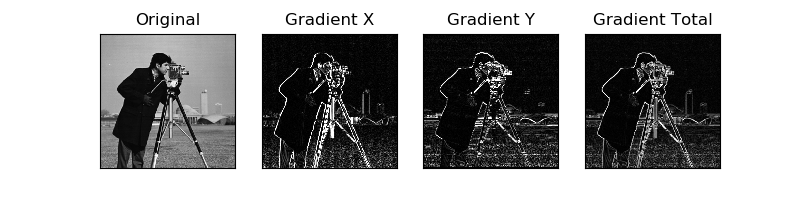

IntSlider(value=3, description='KSize', max=9, min=1, step=2)

FloatSlider(value=1.0, description='Escala', max=2.0, min=-1.0, step=0.2)

In [3]:
sobelBordas('dataset/cameraman.tif')

In [14]:
def laplaceBordas(caminho):
    fig, axes = plt.subplots(1,3,figsize=(8,2), dpi = 100)
    img = cv2.imread(caminho,0)
    ddepth = cv2.CV_16S
    slider = FloatSlider(min=1,max=20,step=1,value=1,description='Escala')

    def update(args):
        k_size = args['new']
        for ax in axes:
            ax.clear()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
        gaussian = cv2.GaussianBlur(img,(5,5),3)
        dst = cv2.Laplacian(gaussian, ddepth, 3, scale=slider.value)
        abs_dst = cv2.convertScaleAbs(dst)
        
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Original')
        axes[1].imshow(gaussian, cmap='gray')
        axes[1].set_title('Suavizada')
        axes[2].imshow((10 * abs_dst), cmap='gray')
        axes[2].set_title('Laplace')

    update({'new':1})
    slider.observe(update, names='value')
    display(slider)

<IPython.core.display.Javascript object>


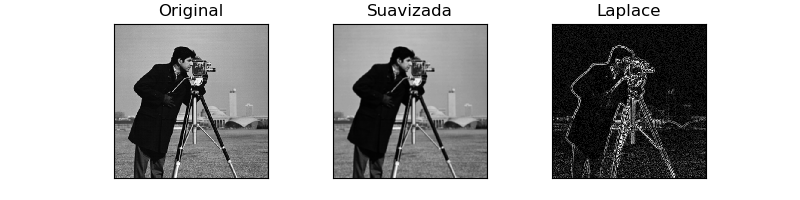

FloatSlider(value=1.0, description='Escala', max=20.0, min=1.0, step=1.0)

In [15]:
laplaceBordas('dataset/cameraman.tif')